In [1]:
#Loading the necessary libraries and data
library(ggplot2)
library(reshape2)
train.1d = read.csv("assignment1_datasets/Task1D_train.csv")
test.1d=read.csv("assignment1_datasets/Task1D_test.csv")

Warning message:
"package 'reshape2' was built under R version 3.6.3"

In [2]:
#Printing the first few rows of data
head(train.1d)

x1,x2,x3,x4,y
5.1,3.5,1.4,0.2,C1
4.7,3.2,1.3,0.2,C1
5.0,3.6,1.4,0.2,C1
4.6,3.4,1.4,0.3,C1
4.4,2.9,1.4,0.2,C1
5.4,3.7,1.5,0.2,C1


In [88]:
D = 4
train.data = train.1d[,1:D]   
train.label = train.1d[,5]  
test.data = test.1d[,1:D]   
test.label = test.1d[,5]

# Scale data
train.data=scale(train.data)

test.data=scale(test.data)

train.len = nrow(train.1d)
test.len = nrow(test.1d)

In [89]:
label = unique(sort(train.label))
label

[1] C1 C2 C3
Levels: C1 C2 C3

In [30]:
#Defining the error function for perceptron 
error_perceptron<-function(Phi,T,Weight,tau){
            #Defining a data frame to hold the predictions 
            pred <- data.frame(matrix(nrow = nrow(Phi), ncol = length(Weight)))
            
            #Predictions for every class
            pred[ ,1] = Phi%*%Weight[[1]][tau,]
            pred[ ,2] = Phi%*%Weight[[2]][tau,]
            pred[ ,3] = Phi%*%Weight[[3]][tau,]
            
            #getting the max column of pred
            len_pred = max.col(pred)
    
            for (i in 1:length(len_pred)){
            
            #We have integer values so we append it with C to enable comparison 
            len_pred[i]=paste('C',len_pred[i],sep='')
                
            }
            
            #Error percentage
            p_err = (sum(len_pred != T)/nrow(pred))*100
            return(p_err)
}

In [110]:
perceptron_for_multiclass <- function(eta,tau.max,epsilon){

#number of columns of X
D = 4

#Getting the training data and label
train.data = train.1d[,1:D]   
train.label = train.1d[,5]  
    
tau <- 1 # iteration counter 
terminate <- FALSE # termination status

# renaming just for conviniance
T <- train.label 
train.len <- nrow(train.data)
Phi <- as.matrix(cbind(1, train.data)) # add a column of 1 to training data        
Weight <- list()

#Defining empty weight vectors of size tau.max x ncol(Phi)
Weight[[1]] <- matrix(,nrow=tau.max, ncol=ncol(Phi)) 
Weight[[2]] <- matrix(,nrow=tau.max, ncol=ncol(Phi)) 
Weight[[3]] <- matrix(,nrow=tau.max, ncol=ncol(Phi)) 
    
    
# Random initial values for weight vectors 
Weight[[1]][1,] <- runif(ncol(Phi))
Weight[[2]][1,] <- runif(ncol(Phi))
Weight[[3]][1,] <- runif(ncol(Phi)) 
    
#Error matrix    
error.trace <- matrix(0,nrow=tau.max, ncol=1)
 
#initialising the error values
error.trace[1,] <- error_perceptron(Phi,T,Weight,1)  
    
# Main Loop (Step 2):
    while(!terminate)
{
    
    # resuffling train data and associated labels:
    train.index <- sample(1:train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]

    for (i in 1:train.len){
        if (tau == tau.max) {break}
        
        #calculating the class values 
        value_c1= Weight[[1]][tau,] %*% Phi[i,]
        value_c2= Weight[[2]][tau,] %*% Phi[i,]
        value_c3= Weight[[3]][tau,] %*% Phi[i,]
        
        #determining which class values is maximum 
        value = list(value_c1,value_c2,value_c3)
        
        predicted.label <- which.max(value)

        # look for missclassified samples
        label = unique(sort(train.label))
        real.label <- which(T[i] == label)
        
        if (real.label!=predicted.label){
            
            # update tau counter
            tau <- tau + 1
            
            #Correcting the weight positions 
            Weight[[1]][tau,] <- Weight[[1]][tau-1,]
            Weight[[2]][tau,] <- Weight[[2]][tau-1,]
            Weight[[3]][tau,] <- Weight[[3]][tau-1,]
            
            # update the weights
            Weight[[real.label]][tau,] <- Weight[[real.label]][tau - 1,] + eta*Phi[i,]
            Weight[[predicted.label]][tau,] <- Weight[[predicted.label]][tau - 1,] - eta*Phi[i,]

             # calculate the error
            error = error_perceptron(Phi,T,Weight,tau)
            error.trace[tau, ] = error

        } 
        
    }
    
    # decrease eta:
    eta = eta * 0.99
    # recalculate termination conditions
    terminate <- tau >= tau.max | error.trace[tau, ] <= epsilon
    
}

#Trimming the Weight vector
Weight[[1]] <- Weight[[1]][1:tau,]
Weight[[2]] <- Weight[[2]][1:tau,]
Weight[[3]] <- Weight[[3]][1:tau,]

return(Weight)
}

In [111]:
set.seed(032350260)
eta <- 0.01 # Learning rate
epsilon <- 0.001 # Stoping criterion
tau.max <- 1000 # Maximum number of iterations

#number of columns of X
D=4

#Loading the test data and labels
test.data = test.1d[,1:D]   
test.label = test.1d[,5]

#Storing the test label
T1 = test.label

test_len <- nrow(test.data)

percept.sample<-list()

#Storing the Weight vector obtained from the above function
percept.sample = perceptron_for_multiclass(eta,tau.max,epsilon)

#Phi matrix for test data
Phi_test = as.matrix(cbind(1, test.data))

#Defining a sequence of data for every 5 values to calculate the error 
sequence_data = seq(from=1, to = nrow(percept.sample[[1]]), by=5) 

error.test <- data.frame()

#Calculating the test error 
for(i in  1:length(sequence_data)){
    error.test[i,'row'] = i
    error.test[i,'test_error'] = error_perceptron(Phi_test,T1,percept.sample,sequence_data[i])
}

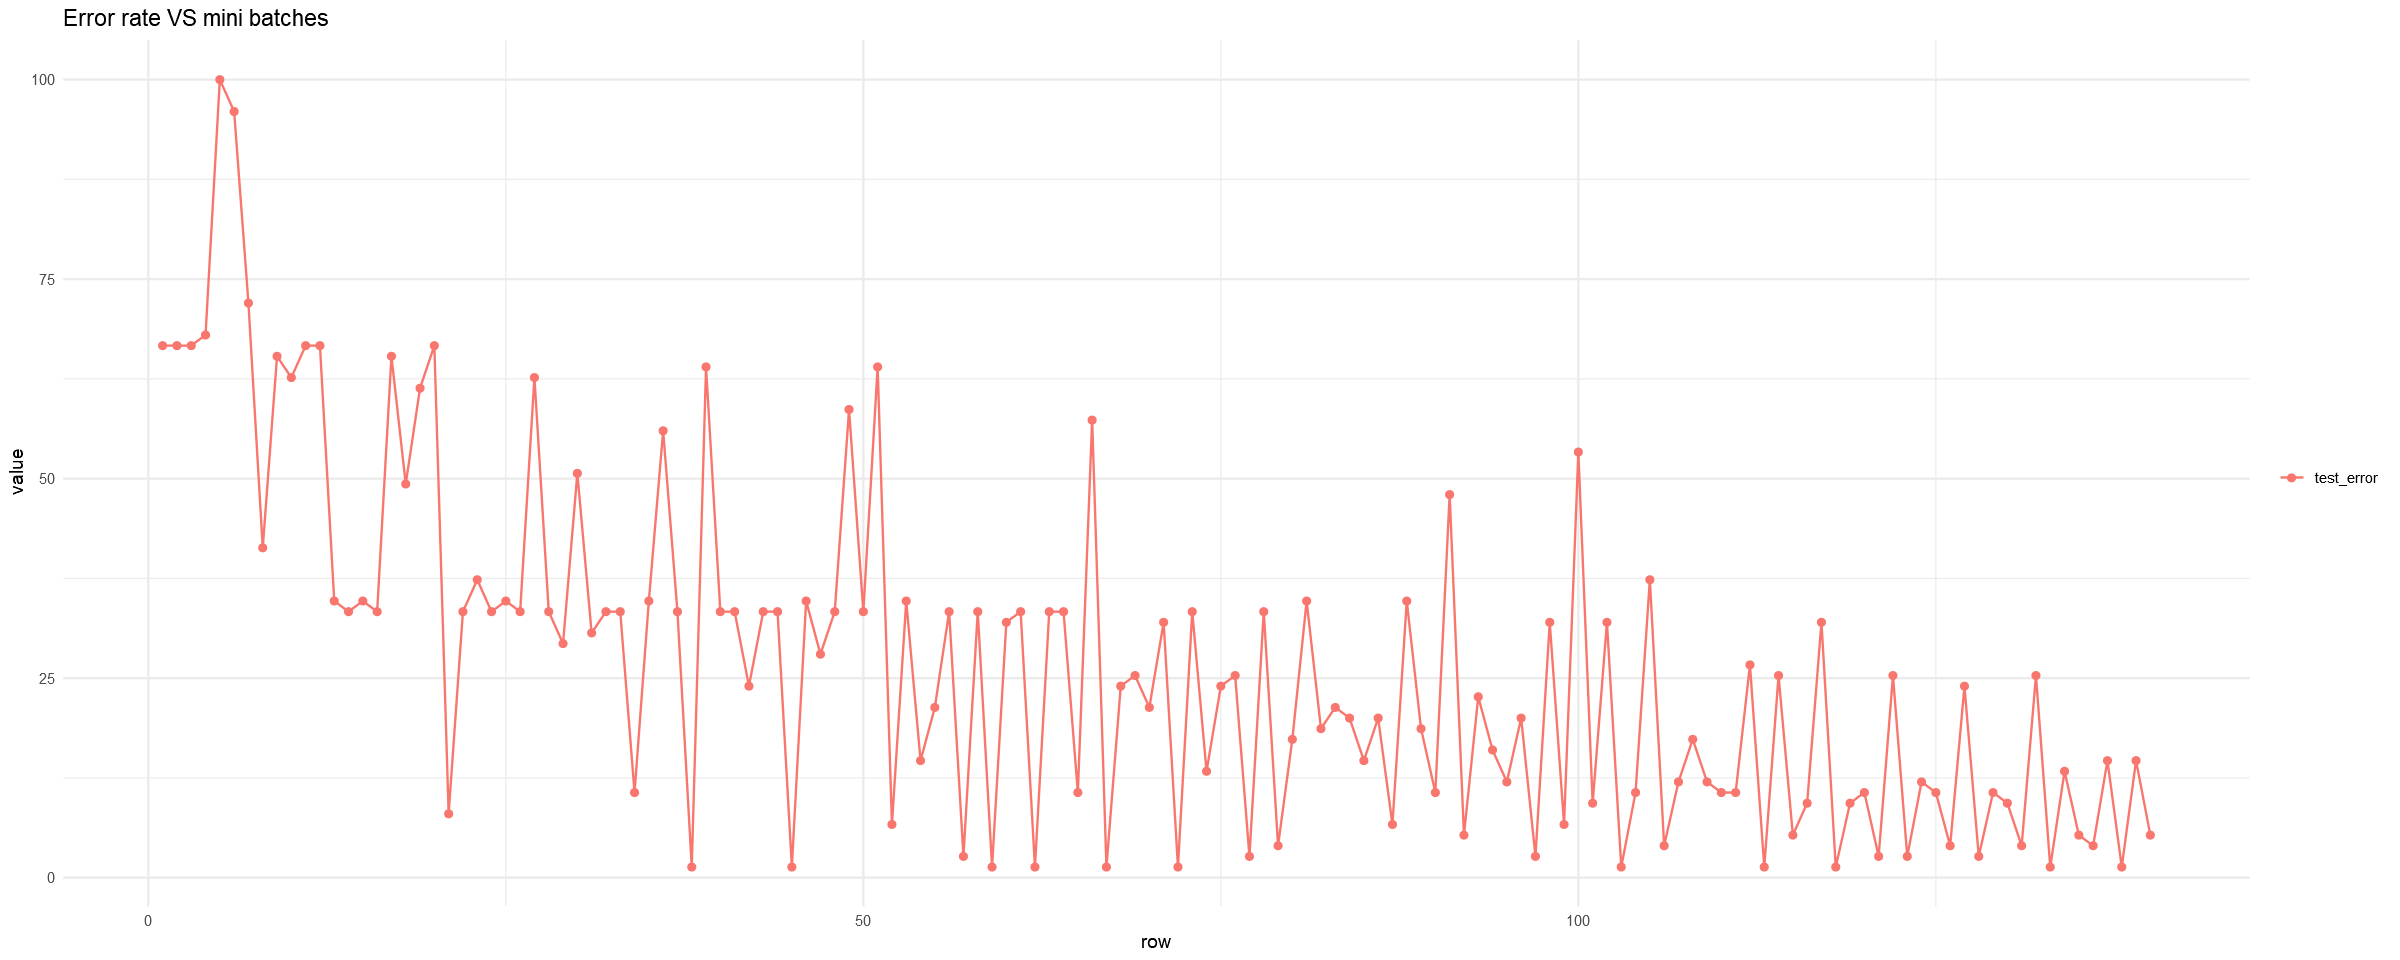

In [103]:
#Plotting the error values vs the mini batches 
error.test_melt <- melt(error.test, id = "row")
options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(data=error.test_melt, aes(x=row, y=value, color=variable))+ theme_minimal()  + geom_point()+
       scale_color_discrete(guide = guide_legend(title = NULL))  + geom_line() +
ggtitle("Error rate VS mini batches")

In [4]:
#Question 6 IV

#Defining the error function for onevsall 
error_onevsall<-function(Phi,T,Weight,tau){
    
             #Defining a data frame to hold the predictions
            pred <- data.frame(matrix(nrow = nrow(Phi), ncol = length(Weight)))
    
            #Predictions for every class
            pred[ ,1] = Phi%*%Weight[[1]][tau,]
            pred[ ,2] = Phi%*%Weight[[2]][tau,]
            
            #Getting the max col of pred
            len_pred = max.col(pred)
            for (i in 1:length(len_pred)){
                
            #We have integer values so we append it with C to enable comparison    
            len_pred[i]=paste('C',len_pred[i],sep='')
                
            }
    
            #Error percentage
            p_err = (sum(len_pred != T)/nrow(pred))*100
            return(p_err)
}

In [119]:
#Defining the function
perceptron_onevsall <- function(eta,tau.max,epsilon,label1){

#Defining the train.data
D = 4
    
train.data = train.1d[,1:D]  

tau <- 1 # iteration counter 
terminate <- FALSE # termination status

T <- label1 # rename just for conviniance
    
#Calculating the length of training data
train.len <- nrow(train.data)
    
# add a column of 1 to training data       
Phi <- as.matrix(cbind(1, train.data))      
Weight <- list()

#Defining empty weight vectors of size tau.max x ncol(Phi)
Weight[[1]] <- matrix(,nrow=tau.max, ncol=ncol(Phi)) 
Weight[[2]] <- matrix(,nrow=tau.max, ncol=ncol(Phi)) 
 
    
    
# Random initial values for weight vectors 
Weight[[1]][1,] <- runif(ncol(Phi))
Weight[[2]][1,] <- runif(ncol(Phi))

#Error matrix       
error.trace <- matrix(0,nrow=tau.max, ncol=1) 
#initialising the error values
error.trace[1,] <- error_onevsall(Phi,T,Weight,1) 
    
# Main Loop (Step 2):
    while(!terminate)
{
    
    # resuffling train data and associated labels:
    train.index <- sample(1:train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]

    for (i in 1:train.len){
        if (tau == tau.max) {break}
        
        #Calculating the class values
        value_c1= Weight[[1]][tau,] %*% Phi[i,]
        value_c2= Weight[[2]][tau,]%*%Phi[i,]

        #determining which class values is maximum 
        value = list(value_c1,value_c2)
        
        predicted.label <- which.max(value)
        
        # look for missclassified samples
        label = unique(sort(train.label))
        real.label <- which(T[i] == label)
        
        if (real.label!=predicted.label){
            
            # update tau counter
            tau <- tau + 1
            
            #Correcting the weight positions 
            Weight[[1]][tau,] <- Weight[[1]][tau-1,]
            Weight[[2]][tau,] <- Weight[[2]][tau-1,]

            
            # update the weights
            Weight[[real.label]][tau,] <- Weight[[real.label]][tau - 1,] + eta*Phi[i,]
            Weight[[predicted.label]][tau,] <- Weight[[predicted.label]][tau - 1,] - eta*Phi[i,]

             # calculate the error
            error = error_onevsall(Phi,T,Weight,tau)
            error.trace[tau, ] = error

        } 
        
    }
    
    # decrease eta:
    eta = eta * 0.99
    # recalculate termination conditions
    terminate <- tau >= tau.max | error.trace[tau, ] <= epsilon
    
}

#Trimming the Weight vector
Weight[[1]] <- Weight[[1]][1:tau,]
Weight[[2]] <- Weight[[2]][1:tau,]

return(Weight)
}

In [117]:
set.seed(32350260)
eta <- 0.01 # Learning rate
epsilon <- 0.001 # Stoping criterion
tau.max <- 1000 # Maximum number of iterations

#Loading the necessary data
D=4

test.data = test.1d[,1:D]   
test.label = test.1d[,5]

#Assigning test label to T1 
T1 = test.label

#For onevsAll, we change class C2 and C3 to one class vs class C1
for (i in 1:length(test.label)){
    if (T1[i] == 'C3')
      {T1[i] ='C2'}
    }

test_len <- nrow(test.data)
percept.sample<-list()
Phi_test = as.matrix(cbind(1, test.data))

error.test <- data.frame()

#Ensuring we have similar set of classes as above for training data for onevsAll
train.label = train.1d[,5]  # training data label
label1=train.label
    for (i in 1:length(train.label)){
    if (train.label[i] == 'C3')
      {
        label1[i] ='C2'
    }

    } 
percept.sample = perceptron_onevsall(eta,tau.max,epsilon,label1)

sequence_data = seq(from=1, to = nrow(percept.sample[[1]]), by=5) 


#Storing corresponding errors in a dataframe

#loop counter to store position of error dataframe
k=1
for(i in  1:length(sequence_data)){
    error.test[i,'row'] = i
    error.test[i,'test_error'] = error_onevsall(Phi_test,T1,percept.sample,sequence_data[i])
    k = k+1
}

#For onevsAll, we change class C2 and C3 to one class vs class C1
T1 = test.label
for (i in 1:length(test.label)){
    if (T1[i] == 'C3')
      {T1[i] ='C1'}
    }

#For onevsAll, we change class C2 and C3 to one class vs class C1 for training data
label2 = train.label
for (i in 1:length(train.label)){
    if (train.label[i] == 'C3')
      {label2[i] ='C1'}

    }  

#Get the weights
percept.sample = perceptron_onevsall(eta,tau.max,epsilon,label2)

#Obtain sequences
sequence_data = seq(from=1, to = nrow(percept.sample[[1]]), by=5) 

#Storing corresponding errors in a dataframe
for(i in  1:length(sequence_data)){
    error.test[k,'row'] = k
    error.test[k,'test_error'] = error_onevsall(Phi_test,T1,percept.sample,sequence_data[i])
    k=k+1
}

#For onevsAll, we change class C2 and C3 to one class vs class C1
T1 = test.label
for (i in 1:length(test.label)){
    if (T1[i] == 'C3')
      {T1[i] ='C2'}
    else
     label3[i]=='C1'
    }

#For onevsAll, we change class C2 and C3 to one class vs class C1 for training data
label3 = train.label
for (i in 1:length(train.label)){
    if (train.label[i] == 'C3')
      {label3[i] ='C2'}
    else
        label3[i]=='C1'
    }  

#Get the weights
percept.sample = perceptron_onevsall(eta,tau.max,epsilon,label3)

#Obtain sequences
sequence_data = seq(from=1, to = nrow(percept.sample[[1]]), by=5) 

#Storing corresponding errors in a dataframe
for(i in  1:length(sequence_data)){
    error.test[k,'row'] = k
    error.test[k,'test_error'] = error_onevsall(Phi_test,T1,percept.sample,sequence_data[i])
    k=k+1
}

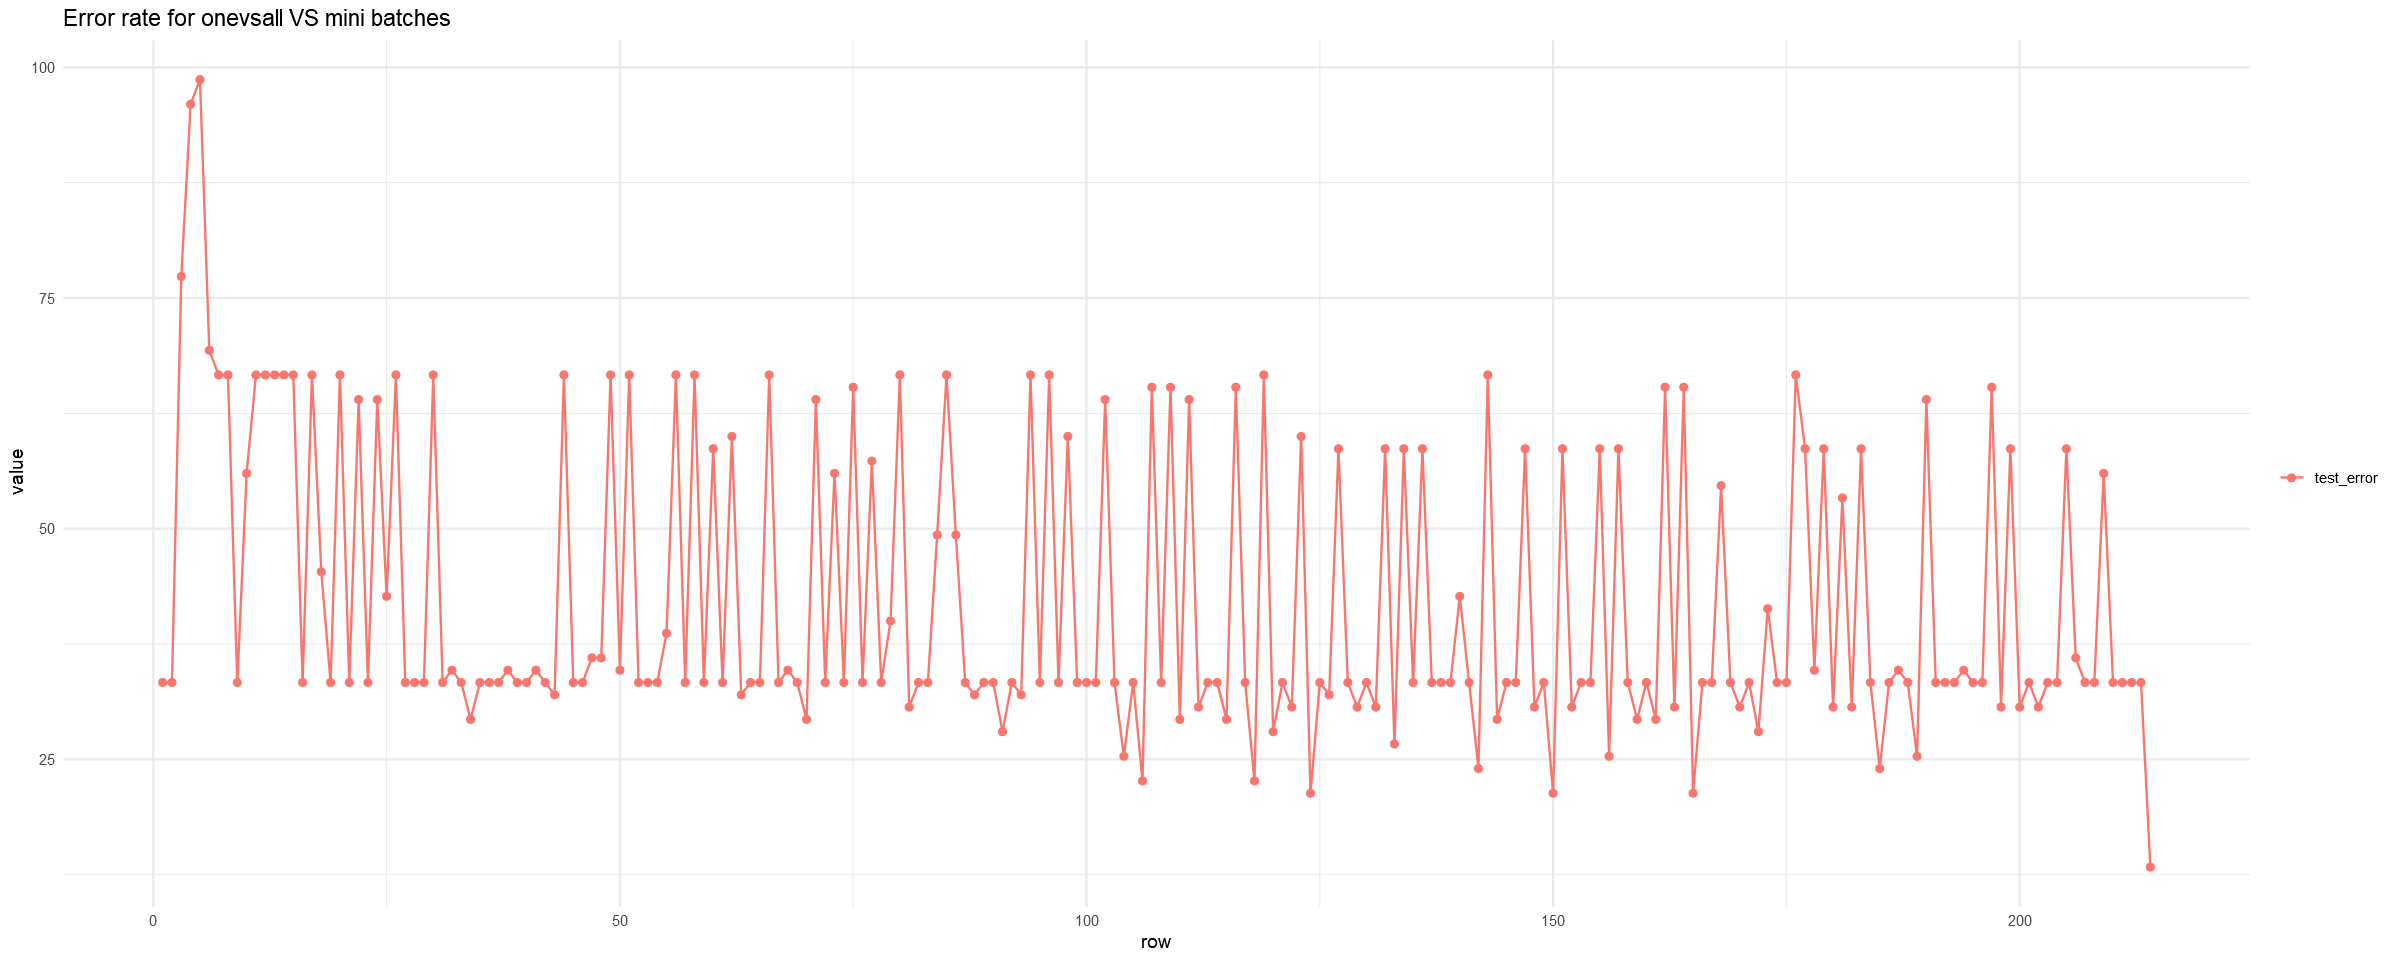

In [118]:
#Plotting the graph for one vs all
error.test_melt <- melt(error.test, id = "row")
options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(data=error.test_melt, aes(x=row, y=value, color=variable))+ theme_minimal()  + geom_point()+
       scale_color_discrete(guide = guide_legend(title = NULL))  + geom_line() +
ggtitle("Error rate for onevsall VS mini batches")